In [1]:
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
from pathlib import Path
import scipy.stats as st
import panel as pn
import geopandas as gpd
import hvplot.pandas


%matplotlib inline

In [2]:
#merged data
merged_obesity_walkscore = Path("../resources/Several_States_Complete.csv")
merged_df = pd.read_csv(merged_obesity_walkscore)
merged_df.head()

,State,CityName,UniqueID,CityFIPS,TractFIPS,ObesityScore,Lat,Lon,WalkScore
0,TX,Houston,4835000-48201451401,4835000.0,4.820145e+10,25.5,29.750367,-95.612367,51.0
1,TX,Garland,4829000-48113018138,4829000.0,4.811302e+10,30.6,32.850897,-96.582081,26.0
2,TX,Mesquite,4847892-48113012500,4847892.0,4.811301e+10,33.4,32.831949,-96.657915,46.0
3,TX,Dallas,4819000-48113004800,4819000.0,4.811300e+10,38.5,32.743677,-96.817550,85.0
4,TX,Fort Worth,4827000-48439105800,4827000.0,4.843911e+10,37.5,32.665385,-97.342787,54.0


In [11]:

# Convert "ObesityScore" and "WalkScore" columns to numeric, coercing non-numeric values to NaN
merged_df["ObesityScore"] = pd.to_numeric(merged_df["ObesityScore"], errors="coerce")
merged_df["WalkScore"] = pd.to_numeric(merged_df["WalkScore"], errors="coerce")

# Create the GeoDataFrame with latitude and longitude and set CRS to EPSG:4326
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df["Lon"], merged_df["Lat"]))
gdf.crs = "EPSG:4326"

# Check for and drop rows with invalid geometries
gdf = gdf[gdf.geometry.is_valid] 

# Create the map plot using hvplot
map_plot = gdf.hvplot(geo=True, tiles="CartoDark", c="State", cmap="Category20", size=15, alpha=0.75,
                      hover_cols=["WalkScore", "ObesityScore"],
                      xlabel="Obesity Rate", ylabel="Walk Score (0-100)",
                      title="Walk Score vs Obesity Rate on US Map")
map_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (State,WalkScore,ObesityScore)

1st Map (Color by State):

Purpose: The first map provides a visual representation of the distribution of walk scores and obesity rates across different states in the US.
Insights:
It allows you to identify the states with higher and lower walk scores and obesity rates at a glance.
The color differentiation helps to distinguish between states and their unique values.
It gives a general sense of how the walk scores and obesity rates are spread across the country.
Analysis:
You can quickly observe which states have high or low walk scores and obesity rates, and potentially look for patterns or correlations based on geographic location.
It helps in understanding the regional variations in walk scores and obesity rates, and any potential clusters of states with similar characteristics.

In [12]:

# Check for and drop rows with invalid geometries
gdf = gdf[gdf.geometry.is_valid]

# Group the data by state and calculate the mean walk score and obesity rate for each state
grouped_data = gdf.groupby("State").agg({"WalkScore": "mean", "ObesityScore": "mean"}).reset_index()
grouped_data.rename(columns={"WalkScore": "WalkScore_mean", "ObesityScore": "ObesityScore_mean"}, inplace=True)

# Merge the aggregated data with the original GeoDataFrame based on the "State" column
gdf = gdf.merge(grouped_data, on="State")

# Create the map plot using hvplot
map_plot = gdf.hvplot(geo=True, tiles="CartoDark", c="ObesityScore_mean", cmap="viridis", size=15, alpha=0.75,
                      hover_cols=["State", "WalkScore_mean", "ObesityScore_mean"],
                      xlabel="Obesity Rate (0-100%)", ylabel="Walk Score (0-100%)",
                      title="Average Walk Score vs Obesity Rate on US Map (Color per Obesity Rate)")

map_plot


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (ObesityScore_mean,State,WalkScore_mean)

2nd Map (Color by Average Obesity Score):

Purpose: The second map focuses on visualizing the average obesity scores for each state, providing a more aggregated view of the data.

Insights:
It highlights the states with higher or lower average obesity rates.
The color intensity helps to differentiate between states based on their average obesity scores, allowing for more precise comparisons.
It emphasizes the states with the most significant health concerns regarding obesity.

Analysis:
You can easily identify states with above-average or below-average obesity rates, making it ideal for targeting specific regions for health interventions or policy measures.
It provides a clearer picture of the states that need more attention in terms of obesity-related initiatives.
By comparing this map with other relevant data (e.g., socioeconomic factors, access to healthcare), you can explore potential correlations and patterns that might explain the obesity rates in different regions.


In summary, the first map provides a detailed view of individual data points (states) and their specific walk scores and obesity rates, while the second map offers a broader overview of the average obesity rates across states. Depending on the analysis goal, either map or both together can be used to gain insights and make data-driven decisions related to walk scores and obesity rates at the state level.


In [38]:
# Calculate the quartiles for ObesityScore
obesity_quartiles = gdf["ObesityScore"].quantile([0.25, 0.5, 0.75])

# Calculate the quartiles for WalkScore
walk_quartiles = gdf["WalkScore"].quantile([0.25, 0.5, 0.75])

print("ObesityScore Quartiles:")
print(obesity_quartiles)

print("\nWalkScore Quartiles:")
print(walk_quartiles)


ObesityScore Quartiles:
0.25    23.0
0.50    28.1
0.75    34.6
Name: ObesityScore, dtype: float64

WalkScore Quartiles:
0.25    26.0
0.50    51.0
0.75    74.0
Name: WalkScore, dtype: float64


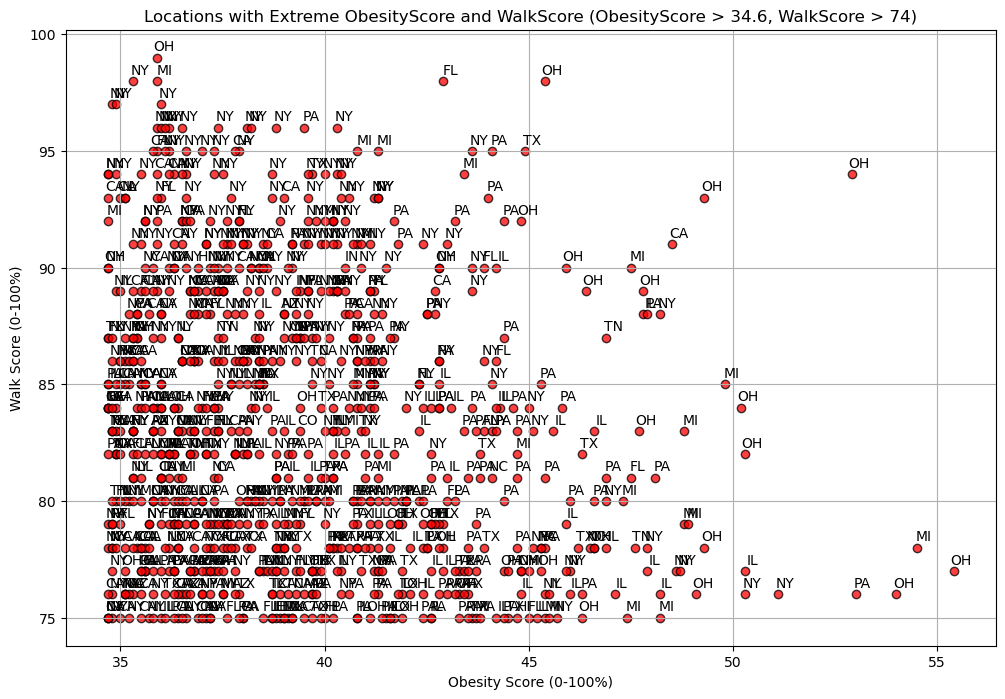

In [5]:
# Create a new column to identify locations with both very low or both very high WalkScore and ObesityScore
gdf = gdf.merge(grouped_data, on="State")

# Filter the GeoDataFrame to only include the locations based on the third quartiles. 
outliers_df = gdf[(gdf["ObesityScore"] > 34.6) & (gdf["WalkScore"] > 74)]

# Create a scatter plot to visualize the outliers
plt.figure(figsize=(12, 8))
plt.scatter(outliers_df["ObesityScore"], outliers_df["WalkScore"], c="red", marker="o", edgecolors="black", alpha=0.75)

# Annotate the points with state labels
for i, row in outliers_df.iterrows():
    plt.annotate(row["State"], (row["ObesityScore"], row["WalkScore"]), textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel("Obesity Score (0-100%)")
plt.ylabel("Walk Score (0-100%)")
plt.title("Locations with Extreme ObesityScore and WalkScore (ObesityScore > 34.6, WalkScore > 74)")
plt.grid(True)
plt.show()

ANALYSIS: 

Upper Right Corner (High ObesityScore and WalkScore): The presence of Ohio in the upper right corner suggests that there are specific locations within the state where residents experience both high ObesityScores and high WalkScores. This indicates that there might be urban areas or neighborhoods in Ohio that offer good walkability and recreational opportunities but also have higher obesity rates. Further investigation into these locations could provide valuable insights for policymakers and urban planners to implement targeted health initiatives.

Upper Left Corner (High ObesityScore and Low WalkScore): The states Ohio, New York (NY), Michigan (MI), Pennsylvania (PA), and California (CA) are located in the upper left corner. This indicates that certain locations within these states have high ObesityScores but relatively low WalkScores. These areas might have limited access to walkable infrastructure, such as sidewalks, parks, and recreational facilities, which could contribute to lower physical activity levels and higher obesity rates. Addressing the walkability and access to physical activity opportunities in these locations could be beneficial for promoting healthier lifestyles.

Bottom Right Corner (Low ObesityScore and High WalkScore): The states Ohio, Michigan (MI), Pennsylvania (PA), New York (NY), and Illinois (IL) are situated in the bottom right corner. This suggests that there are specific areas within these states where residents enjoy both low ObesityScores and high WalkScores. These locations may be characterized by well-planned urban environments, extensive recreational facilities, and better access to healthy food options, contributing to lower obesity rates and encouraging active lifestyles. Identifying the factors contributing to these positive outcomes can inform policies aimed at promoting health and well-being.

Bottom Left Corner (Low ObesityScore and Low WalkScore): Due to the high density of points in the bottom left corner, it is challenging to identify specific states. However, this corner represents locations with both low ObesityScores and low WalkScores. These areas might be rural or have limited access to infrastructure that promotes physical activity, potentially leading to lower obesity rates. Policymakers could focus on improving the walkability and recreational opportunities in these regions to further encourage active living.

In summary, the updated analysis based on the specific states in each corner of the scatter plot provides a more detailed understanding of the relationship between ObesityScore and WalkScore in various locations. It highlights states with unique characteristics in terms of walkability and obesity rates, offering insights for targeted interventions and policies to improve health outcomes in different areas. However, it is essential to consider additional factors and conduct further research to better understand the underlying reasons for the observed patterns.

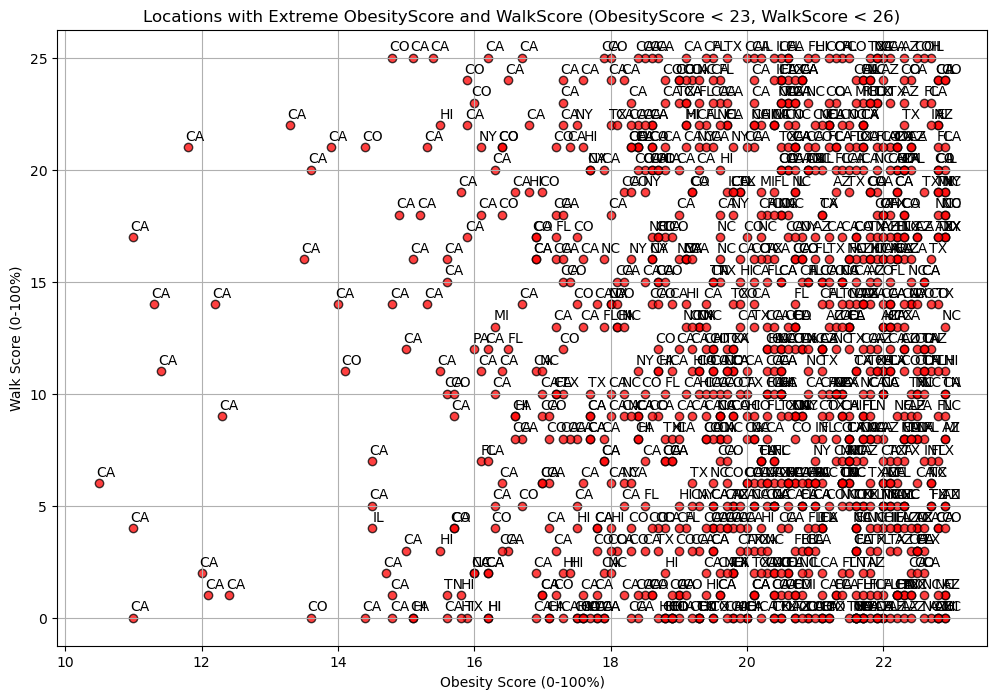

In [13]:
# Filter the GeoDataFrame to only include the locations based on the first quartile
outliers_df = gdf[(gdf["ObesityScore"] < 23.0) & (gdf["WalkScore"] < 26)]

# Create a scatter plot to visualize the outliers
plt.figure(figsize=(12, 8))
plt.scatter(outliers_df["ObesityScore"], outliers_df["WalkScore"], c="red", marker="o", edgecolors="black", alpha=0.75)

# Annotate the points with state labels
for i, row in outliers_df.iterrows():
    plt.annotate(row["State"], (row["ObesityScore"], row["WalkScore"]), textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel("Obesity Score (0-100%)")
plt.ylabel("Walk Score (0-100%)")
plt.title("Locations with Extreme ObesityScore and WalkScore (ObesityScore < 23, WalkScore < 26)")
plt.grid(True)
plt.show()

ANALYSIS: 

The scatter plot displays locations where both ObesityScore and WalkScore fall below the first quartile of each respective variable. Let's analyze the findings based on the identified states in each corner:

Upper Right Corner: States with low ObesityScore and low WalkScore include Texas (TX), California (CA), and Arizona (AZ). These states have areas with relatively low obesity rates and less walkable environments, which may indicate that physical activity and walkability are not major contributors to obesity in these regions.

Upper Left Corner: California (CA) is the only state in this corner. It shows locations within California where both ObesityScore and WalkScore are below the first quartile. This suggests that there are specific areas in California with relatively low obesity rates and less walkable neighborhoods.

Bottom Right Corner: States with low ObesityScore and high WalkScore include California (CA) and Florida (FL). These states have areas with relatively low obesity rates and high walkability, indicating that factors contributing to lower obesity rates may align with more walkable environments.

Bottom Left Corner: California (CA) is again the only state in this corner. It shows locations within California where both ObesityScore and WalkScore are above the first quartile. This suggests that there are specific areas in California with higher obesity rates and more walkable neighborhoods.

Overall, the scatter plot and analysis provide insights into the relationship between ObesityScore and WalkScore for different states in the United States. It identifies specific states and areas within them that exhibit low and high levels of obesity and walkability. The data can be used to further explore factors contributing to obesity rates and walkability in different regions and to make informed decisions for public health and urban planning initiatives. However, it is important to consider that correlations observed in this analysis do not imply causation, and further research and analysis would be required to establish causal relationships between these variables.